## Flight Delay Analyisis

In this notebook, we develop a simple model to predict flight delays. We start by exploring the dataset, building a simple baseline model and then building a deep neural network. 

In [16]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import datetime
%matplotlib inline
import time
import math
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Reading from csv files

In [3]:
march_data = pd.read_csv('./sample_data_mar_2018.csv')
feb_data = pd.read_csv('./sample_data_feb_2018.csv')
data = pd.concat([march_data, feb_data], axis=0)
data.head()

,departure_date,airline_code,flight_number,source_airport,destination_airport,flight_status,departure_scheduled_time,departure_actual_time,arrival_scheduled_time,arrival_actual_time
0,2018-03-01,BA,920,LHR,STR,LANDED,1.519921e+09,1519920720,1.519927e+09,1.519926e+09
1,2018-03-01,EI,381,LHR,SNN,LANDED,1.519898e+09,1519900680,1.519903e+09,1.519906e+09
2,2018-03-01,OS,7853,LHR,ORD,LANDED,1.519918e+09,1519917960,1.519951e+09,1.519949e+09
3,2018-03-01,AA,6237,LHR,AUS,LANDED,1.519903e+09,1519903440,1.519941e+09,1.519940e+09
4,2018-03-01,QR,5547,LHR,DFW,LANDED,1.519899e+09,1519901760,1.519936e+09,1.519937e+09


We notice that the flight status and flight number are not useful in determining if a flight gets delayed or not. 
Hence we remove them.

In [4]:
data.dropna(how='any', axis = 0, inplace=True)
data = data.drop(['flight_status', 'flight_number'], axis=1)

Python's Datetime format convenient to work with dates and times and we use it to  convert the dates in this format

In [5]:
data['departure_date'] = pd.to_datetime(data['departure_date'])
data['departure_scheduled_time'] = pd.to_datetime(data['departure_scheduled_time'], unit='s')
data['departure_actual_time'] = pd.to_datetime(data['departure_actual_time'], unit='s')
data['arrival_scheduled_time'] = pd.to_datetime(data['arrival_scheduled_time'], unit='s')
data['arrival_actual_time'] = pd.to_datetime(data['arrival_actual_time'], unit='s')

Calculating arrival delay time fot our label since this a supervised learning problem. We also use
departure delay time which may be useful for our models.

In [6]:
data['arrival_delay'] = (data['arrival_actual_time'] - data['arrival_scheduled_time']).astype('timedelta64[m]')
data['departure_delay'] = (data['departure_actual_time'] - data['departure_scheduled_time']).astype('timedelta64[m]')

We extract all the information such as day, month, year from scheduled arrival and departure times. We do not use expected or actual times since they will not be avialable while prediction a new entry.

In [7]:
data['departure_scheduled_time_weekday'] = data['departure_scheduled_time'].dt.dayofweek
data['departure_scheduled_time_day'] = data['departure_scheduled_time'].dt.day
data['departure_scheduled_time_month'] = data['departure_scheduled_time'].dt.month
data['departure_scheduled_time_year'] = data['departure_scheduled_time'].dt.year

data['arrival_scheduled_time_day_weekday'] = data['arrival_scheduled_time'].dt.dayofweek
data['arrival_scheduled_time_day'] = data['arrival_scheduled_time'].dt.day
data['arrival_scheduled_time_month'] = data['arrival_scheduled_time'].dt.month
data['arrival_scheduled_time_year'] = data['arrival_scheduled_time'].dt.year

In [13]:
data.head()

,departure_date,airline_code,source_airport,destination_airport,departure_scheduled_time,departure_actual_time,arrival_scheduled_time,arrival_actual_time,arrival_delay,departure_delay,departure_scheduled_time_weekday,departure_scheduled_time_day,departure_scheduled_time_month,departure_scheduled_time_year,arrival_scheduled_time_day_weekday,arrival_scheduled_time_day,arrival_scheduled_time_month,arrival_scheduled_time_year,airline
0,2018-03-01,BA,LHR,STR,2018-03-01 16:10:00,2018-03-01 16:12:00,2018-03-01 17:50:00,2018-03-01 17:38:00,-12.0,2.0,3,1,3,2018,3,1,3,2018,14
1,2018-03-01,EI,LHR,SNN,2018-03-01 09:50:00,2018-03-01 10:38:00,2018-03-01 11:15:00,2018-03-01 12:01:00,46.0,48.0,3,1,3,2018,3,1,3,2018,28
2,2018-03-01,OS,LHR,ORD,2018-03-01 15:20:00,2018-03-01 15:26:00,2018-03-02 00:35:00,2018-03-02 00:11:00,-24.0,6.0,3,1,3,2018,4,2,3,2018,68
3,2018-03-01,AA,LHR,AUS,2018-03-01 11:20:00,2018-03-01 11:24:00,2018-03-01 21:55:00,2018-03-01 21:37:00,-18.0,4.0,3,1,3,2018,3,1,3,2018,3
4,2018-03-01,QR,LHR,DFW,2018-03-01 10:10:00,2018-03-01 10:56:00,2018-03-01 20:35:00,2018-03-01 20:40:00,5.0,46.0,3,1,3,2018,3,1,3,2018,74


Visualisations - Delay rate of each airline

14 BA
28 EI
68 OS
3 AA
74 QR
85 SV
2 A3
4 AC
65 NH
72 PR
30 ET
90 UA
24 CX
51 KL
80 SA
12 AY
58 LY
47 JL
29 EK
6 AF
41 IB
55 LH
86 TG
82 SN
75 RJ
59 ME
81 SK
88 TP
37 GF
26 DL
9 AM
11 AV
87 TK
73 QF
83 SQ
95 VS
61 MH
25 CZ
91 UL
46 JJ
32 EY
53 KQ
92 UU
13 AZ
8 AI
84 SU
64 MU
66 NZ
35 G3
1 9W
70 OZ
36 GA
96 VY
57 LX
56 LO
97 WY
0 4U
38 HM
27 DT
93 VA
63 MS
10 AT
52 KM
49 KC
42 IG
79 S7
99 XY
22 CI
34 FI
60 MF
94 VN
17 BI
50 KE
71 PK
39 HU
69 OU
62 MK
21 CA
76 RO
19 BR
18 BM
33 FB
20 BT
7 AH
54 KU
15 BE
5 AD
98 X3
45 JD
89 TU
43 IR
16 BG
44 J2
31 EW
40 HY
48 JP
67 OK
101 ZT
78 S4
23 CO
77 RU
100 ZI


/anaconda/envs/tensorflow/lib/python3.5/site-packages/matplotlib/cbook.py:2649: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


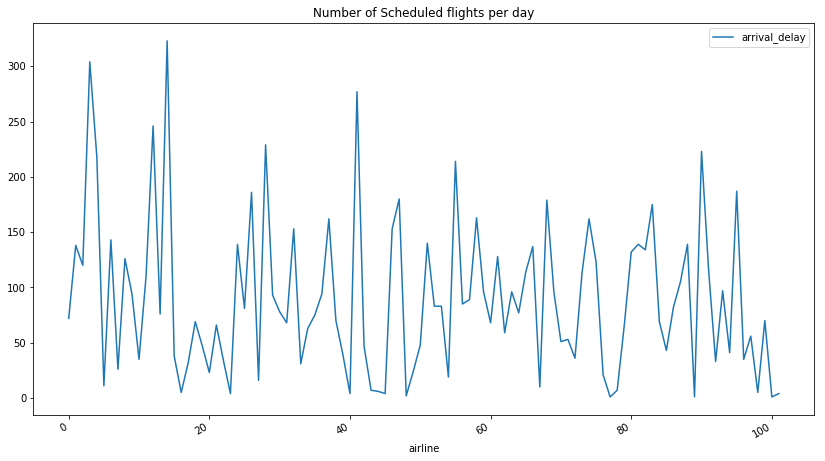

In [17]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
data['airline'] = le.fit_transform(data['airline_code'])

for i in data['airline'].unique():
    print (i , le.inverse_transform(i))

a = data.groupby('airline').nunique()['arrival_delay']
a.plot(kind='line' ,subplots=True,c='a', figsize=(14,8),legend=True)
plt.title('Number of Scheduled flights per day')
plt.show()

Converting all categorical variables and defining the target label. 

In [18]:
data = pd.get_dummies(data, columns=["airline_code", "destination_airport", "source_airport"], prefix=["airline_code", "destination_airport", "source_airport"])
data['delayed'] = data['arrival_delay'] >= 30

To get confidence scores for each prediction, we define the targets as a 2D array. We will then use softmax cross entropy(log loss) for predictions. 

In [19]:
# [0,1] if delayed else [1,0]
isDelayed = np.array(data['delayed'])

delayed = np.zeros((data.shape[0], 2))
print (delayed.shape)
for i in range(len(delayed)):
    if isDelayed[i] == False:
        delayed[i][0] = 1
    else:
        delayed[i][1] = 1

(100637, 2)


Removing unnecessary features. Here we define seperate target variables: Y which is 1D for our baseline model (since we only want to observe how the baseline performs)and Y_confindence which is 2D for our deep neural network. 

In [20]:
to_remove = ['arrival_delay',
             'departure_date',
             'departure_scheduled_time',
             'departure_actual_time',
             'arrival_scheduled_time', 
             'arrival_actual_time',
             'delayed']

Y = np.reshape(np.array(data['delayed']), (data.shape[0], 1))
Y_confidence = delayed
X = np.array(data.drop(to_remove, axis = 1))

Defining two helper functions:
- train_test_split: Splitting the dataset into training, validation and test sets
- get_batches: Generating batches for our deep neural network

In [21]:
def train_test_split(data, split_ratio, shuffle=True):
    if shuffle == True:
        np.random.shuffle(data)

    idx = int(len(data) * split_ratio)
    train_data, test_data = data[:idx], data[idx:]

    return train_data, test_data

def get_batches(X, Y, batch_size = 128):
    counts = len(X)
    num_batches = counts // batch_size
    
    for i in range(0, counts, batch_size):
        x = X[i:min(i + batch_size, counts)]
        y = Y[i:min(i + batch_size, counts)]
        yield x, y

Splitting our dataset into training, validation and test sets

In [22]:
X_train, x = train_test_split(X, split_ratio=0.8, shuffle=False)
y_train, y = train_test_split(Y_confidence, split_ratio=0.8, shuffle=False)

X_val, X_test = train_test_split(x, split_ratio=0.5, shuffle=False)
y_val, y_test = train_test_split(y, split_ratio=0.5, shuffle=False)

print ("Train Input Shape: ", X_train.shape)
print ("Train Target Shape: ", y_train.shape)

print ("Validation Input Shape: ",X_val.shape)
print ("Validation Target Shape: ",y_val.shape)

print ("Test Input Shape: ",X_test.shape)
print ("Test Target Shape: ",y_test.shape)

Train Input Shape:  (80509, 301)
Train Target Shape:  (80509, 2)
Validation Input Shape:  (10064, 301)
Validation Target Shape:  (10064, 2)
Test Input Shape:  (10064, 301)
Test Target Shape:  (10064, 2)


#### Simple Baseline Model

Here we use Tensorflow's newly available estimators. Estimators are pre-build computation graphs. The baseline classifier returns the probability distribution of the classes as seen in the labels. For multi-label problems, this will predict the fraction of examples that are positive for each class.

In [23]:
import tensorflow as tf
import numpy as np

X_, x_ = train_test_split(X, split_ratio=0.8, shuffle=False)
Y_, y_ = train_test_split(Y, split_ratio=0.8, shuffle=False)

def input_fn_train(X, y):
    return X, y

def input_fn_test(X, y):
    return X, y

classifier = tf.estimator.BaselineClassifier(n_classes=2)

train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": input_fn_train(X_, Y_)[0]},
    y=input_fn_train(X_, Y_)[1],
    num_epochs=30,
    batch_size=256,
    shuffle=True
)

classifier.train(input_fn=train_input_fn, steps=100)

# Define the test inputs
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": input_fn_test(x_, y_)[0]},
    y=input_fn_test(x_, y_)[1],
    num_epochs=1,
    shuffle=False
)

# Evaluate accuracy
accuracy_score = classifier.evaluate(input_fn=test_input_fn)["accuracy"]
print ('\n')
print('Test Accuracy: {:.1f} %'.format(accuracy_score*100))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_keep_checkpoint_max': 5, '_master': '', '_task_id': 0, '_global_id_in_cluster': 0, '_evaluation_master': '', '_save_summary_steps': 100, '_session_config': None, '_num_worker_replicas': 1, '_service': None, '_tf_random_seed': None, '_save_checkpoints_steps': None, '_model_dir': '/var/folders/vv/fxyl2yq11hv5h9ntcpl8rlqh0000gn/T/tmp6wjbhogb', '_num_ps_replicas': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1192e3f98>, '_task_type': 'worker', '_log_step_count_steps': 100, '_save_checkpoints_secs': 600, '_keep_checkpoint_every_n_hours': 10000}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/vv/fxyl2yq11hv5h9ntcpl8rlqh000

#### Deep Neural Network

We now build our 3 layer simple DNN. After final preprocessing, we have 300 features and a 2D target. Number of units(neurons) for the 2 hidden layers are 64, 32 respectively and relu non-linearities are used. The loss function is softmax cross entropy and the network is trained using Adam Optimizer which uses an exponentially decaying average of past gradients with vanilla gradient descent.

In [25]:
tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, shape=(None, 301))
targets = tf.placeholder(tf.float32, shape=(None, 2))
lr = tf.placeholder(tf.float32)
pkeep = tf.placeholder(tf.float32)

W1 = tf.get_variable(name='W1', shape=(301, 64), initializer=tf.contrib.layers.xavier_initializer())
b1 = tf.Variable(tf.ones(64))

W2 = tf.get_variable(name='W2', shape=(64, 32), initializer=tf.contrib.layers.xavier_initializer())
b2 = tf.Variable(tf.ones(32))

W3 =tf.get_variable(name='W3', shape=(32, 2), initializer=tf.contrib.layers.xavier_initializer())
b3 = tf.Variable(tf.ones(2))

x = tf.nn.relu(tf.add(tf.matmul(inputs, W1), b1))
x = tf.nn.relu(tf.add(tf.matmul(x, W2), b2))
y = tf.add(tf.matmul(x, W3), b3)
y_ = tf.nn.softmax(y)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=targets, logits=y))
optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_, 1), tf.argmax(targets, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Defining the training loop

In [26]:
init = tf.global_variables_initializer()
#tf.Session.reset(targets, containers=None, config=None)
saver = tf.train.Saver()

sess = tf.Session()
epochs = 30
total_time = 0
# Start training
with sess:
    sess.run(init)
    for epoch in range(epochs+1):
        start = time.time()
        for x, y in get_batches(X_train, y_train, 256):
            max_learning_rate = 0.003
            min_learning_rate = 0.0001
            decay_speed = 2000.0
            learn = min_learning_rate + (max_learning_rate - min_learning_rate) * math.exp(-epoch/decay_speed)
            
            _, l, acc  = sess.run([optimizer, loss, accuracy], feed_dict={inputs:x, targets:y, lr:learn, pkeep:0.8})
        
        end = time.time()    

        if epoch % 5 == 0:
            print ('Epoch:{}, Loss:{:.2f}, Accuracy:{} %, Time Taken Per Epoch:{:.2f} secs, Total Time Elapsed:{:.2f} secs'.format(epoch, l, acc*100, (end - start), (total_time)))   
        if epoch % 10 == 0:
            print("----Validation Accuracy:{} % after {} epochs---- ".format(accuracy.eval(feed_dict={inputs: X_val, targets: y_val, pkeep: 1.0})*100, epoch))
        
        total_time += (end - start)
    save_path = saver.save(sess, 'models/model.ckpt') 
    print ("  ")
    print("Model saved in path: %s" % save_path)

Epoch:0, Loss:0.31, Accuracy:87.99999952316284 %, Time Taken Per Epoch:0.72 secs, Total Time Elapsed:0.00 secs
----Validation Accuracy:87.99682259559631 % after 0 epochs---- 
Epoch:5, Loss:0.17, Accuracy:94.40000057220459 %, Time Taken Per Epoch:0.68 secs, Total Time Elapsed:3.43 secs
Epoch:10, Loss:0.17, Accuracy:95.20000219345093 %, Time Taken Per Epoch:0.67 secs, Total Time Elapsed:6.79 secs
----Validation Accuracy:95.11128664016724 % after 10 epochs---- 
Epoch:15, Loss:0.17, Accuracy:95.20000219345093 %, Time Taken Per Epoch:0.67 secs, Total Time Elapsed:10.14 secs
Epoch:20, Loss:0.19, Accuracy:95.20000219345093 %, Time Taken Per Epoch:0.67 secs, Total Time Elapsed:13.49 secs
----Validation Accuracy:95.22058963775635 % after 20 epochs---- 
Epoch:25, Loss:0.20, Accuracy:95.20000219345093 %, Time Taken Per Epoch:0.67 secs, Total Time Elapsed:16.84 secs
Epoch:30, Loss:0.21, Accuracy:95.20000219345093 %, Time Taken Per Epoch:0.67 secs, Total Time Elapsed:20.20 secs
----Validation Accur

Using the saved model to predict on test set.

In [27]:
sess = tf.Session()
with sess:

    saver.restore(sess, "models/model.ckpt")
    print("Model restored.")
    # Check the values of the variables
    print("Validation Accuracy:{} %".format(accuracy.eval(feed_dict={inputs: X_test, targets: y_test, pkeep: 1.0})*100))

INFO:tensorflow:Restoring parameters from models/model.ckpt
Model restored.
Validation Accuracy:90.62997102737427 %


We see that accuracy is better than our baseline model for both validation set and test set. But the model is clearly overfitting since we do not have enough features available. Flight delays depend on a lot of factors such as weather conditons, etc. and hence the loss for our simple Deep neural network becomes stagnant after some time. 